# SIT 215 - Final Submission - Ujjwal

In [1]:
class Problem(object):

    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal
    def is_in(self,elt, seq):
        """Similar to (elt in seq), but compares with 'is', not '=='."""
        return any(x is elt for x in seq)

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return self.is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2.  If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value.  Hill-climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError

In [2]:
class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

In [3]:
import math
import numpy as np

In [4]:
class GraphProblem(Problem):

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph
        self.infinity=math.inf
    def distance(self,a, b):
        """The distance between two (x, y) points."""
        xA, yA = a
        xB, yB = b
        return np.hypot((xA - xB), (yA - yB))
    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or self.infinity)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = self.infinity
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(self.distance(locs[node], locs[self.goal]))

            return int(self.distance(locs[node.state], locs[self.goal]))
        else:
            return self.infinity

In [5]:
class Graph:
    """A graph connects nodes (vertices) by edges (links). Each edge can also
    have a length associated with it. The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C. You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added. You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B. 'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


def UndirectedGraph(graph_dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(graph_dict=graph_dict, directed=False)

In [6]:

melbourne_map = UndirectedGraph(dict(
    Rebel_Melbourne=dict(StrandBags=7, NW_Computing=6),
    StrandBags=dict(Rebel_Melbourne=7, Telstra=9, Gopals_Vegetarian=5),
    NW_Computing=dict(Rebel_Melbourne=6, Travellers_Shop=10, Telstra=4),
    Travellers_Shop=dict(NW_Computing=10, Simpsons_Burger=8),
    Simpsons_Burger=dict(Travellers_Shop=8, Flinders_Station_Entry=7, Ian_Potter_Centre_of_Arts=3),
    Flinders_Station_Entry=dict(Simpsons_Burger=7, Ian_Potter_Centre_of_Arts=12),
    Ian_Potter_Centre_of_Arts=dict(Flinders_Station_Entry=12, Wheelchair_Accessible_Parking=9, Gopals_Vegetarian=2),
    Wheelchair_Accessible_Parking=dict(Ian_Potter_Centre_of_Arts=9, Telstra=11),
    Telstra=dict(Wheelchair_Accessible_Parking=11, StrandBags=9, National_Health_Academy=7, NW_Computing=4),
    National_Health_Academy=dict(Telstra=7, Melbourne_Marriott=6, Novotel=3),
    Melbourne_Marriott=dict(National_Health_Academy=6, RMIT_University=10, Novotel=5),
    RMIT_University=dict(Melbourne_Marriott=10, State_Library_Victoria=11, County_Court_Victoria=4),
    State_Library_Victoria=dict(RMIT_University=11, Pepes_Italian=9),
    Pepes_Italian=dict(State_Library_Victoria=9),
    Gopals_Vegetarian=dict(StrandBags=5, Ian_Potter_Centre_of_Arts=2),
    Novotel=dict(Melbourne_Marriott=5, National_Health_Academy=3),
    County_Court_Victoria=dict(RMIT_University=4),
))


# Define the locations of each suburb in Melbourne

melbourne_map.locations = dict(
    Rebel_Melbourne=(144.963238, -37.8142406),
    StrandBags=(144.9656412, -37.8135287),
    State_Library_Victoria=(144.9638549, -37.8096635),
    NW_Computing=(144.9607548, -37.8149595),
    Gopals_Vegetarian=(144.9660652, -37.8144847),
    Morris_House=(144.9709469, -37.8130439),
    Telstra=(144.9680501, -37.8128383),
    National_Health_Academy=(144.9671167, -37.8108655),
    Melbourne_Marriott=(144.9695628, -37.8101111),
    RMIT_University=(144.9662154, -37.8089456),
    Flinders_Lane=(144.9670218, -37.8164705),
    Travellers_Shop=(144.9645709, -37.8172049),
    Simpsons_Burger=(144.960696, -37.8182821),
    Wheelchair_Accessible_Parking=(144.9730821, -37.81141),
    Ian_Potter_Centre_of_Arts=(144.9697776, -37.8165464),
    Novotel=(144.959553, -37.8119483),
    County_Court_Victoria=(144.9576635, -37.8135015),
    Flinders_Station_Entry=(144.9648598, -37.8181007),
    UniLodge_Housing=(144.960345, -37.8107083),
    Pepes_Italian=(144.9691132, -37.8091831)
)


In [7]:
# Define the Melbourne problem
melbourne_problem = GraphProblem('Pepes_Italian', 'Simpsons_Burger', melbourne_map)

In [8]:
melbourne_locations = melbourne_map.locations
print(melbourne_locations)

{'Rebel_Melbourne': (144.963238, -37.8142406), 'StrandBags': (144.9656412, -37.8135287), 'State_Library_Victoria': (144.9638549, -37.8096635), 'NW_Computing': (144.9607548, -37.8149595), 'Gopals_Vegetarian': (144.9660652, -37.8144847), 'Morris_House': (144.9709469, -37.8130439), 'Telstra': (144.9680501, -37.8128383), 'National_Health_Academy': (144.9671167, -37.8108655), 'Melbourne_Marriott': (144.9695628, -37.8101111), 'RMIT_University': (144.9662154, -37.8089456), 'Flinders_Lane': (144.9670218, -37.8164705), 'Travellers_Shop': (144.9645709, -37.8172049), 'Simpsons_Burger': (144.960696, -37.8182821), 'Wheelchair_Accessible_Parking': (144.9730821, -37.81141), 'Ian_Potter_Centre_of_Arts': (144.9697776, -37.8165464), 'Novotel': (144.959553, -37.8119483), 'County_Court_Victoria': (144.9576635, -37.8135015), 'Flinders_Station_Entry': (144.9648598, -37.8181007), 'UniLodge_Housing': (144.960345, -37.8107083), 'Pepes_Italian': (144.9691132, -37.8091831)}


In [9]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in melbourne_map.locations.keys()}
node_positions = melbourne_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in melbourne_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in melbourne_map.graph_dict.items() for k2, v2 in v.items()}

melbourne_graph_data = {  'graph_dict' : melbourne_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

In [10]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # set the size of the plot
    plt.figure(figsize=(10, 7))
    # draw the graph (both nodes and edges) with locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k',with_labels = True)

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)

    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution'),
               numpoints=1, prop={'size': 16}, loc=(.9, .75))

    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

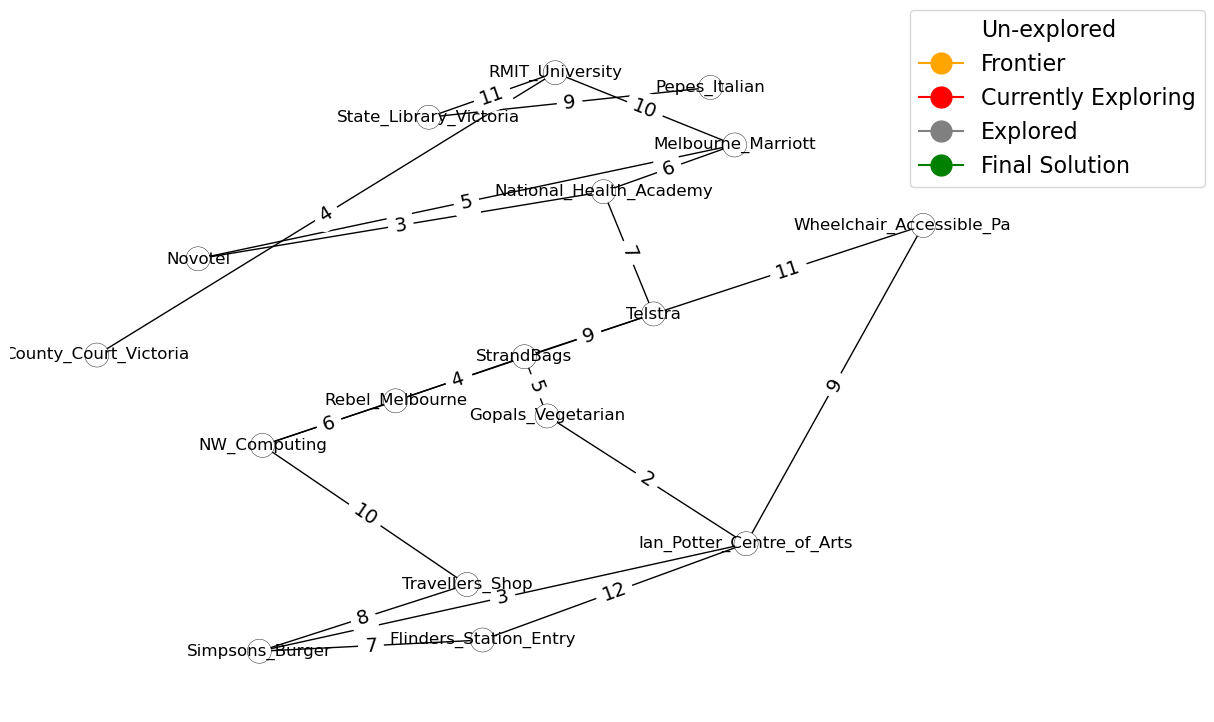

In [11]:
show_map(melbourne_graph_data)

In [12]:
import heapq

In [13]:
import functools

In [14]:
def final_path_colors(initial_node_colors, problem, solution):
    "Return a node_colors dict of the final path provided the problem and solution."

    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"
    return final_colors
def display_visual(graph_data, user_input, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_colors']
    if user_input is False:
        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(graph_data, node_colors=all_node_colors[iteration])
            except:
                pass

        def visualize_callback(visualize):
            if visualize is True:
                button.value = False

                global all_node_colors

                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))

                slider.max = len(all_node_colors) - 1

                for i in range(slider.max + 1):
                    slider.value = i
                    time.sleep(.5)

        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration=slider)
        display(slider_visual)

        button = widgets.ToggleButton(value=False)
        button_visual = widgets.interactive(visualize_callback, visualize=button)
        display(button_visual)

    if user_input is True:
        node_colors = dict(initial_node_colors)
        if isinstance(algorithm, dict):
            assert set(algorithm.keys()).issubset({"Breadth First Search",
                                                   "Depth First Search",})

            algo_dropdown = widgets.Dropdown(description="Search algorithm: ",
                                             options=sorted(list(algorithm.keys())),
                                             value="Breadth First Tree Search")
            display(algo_dropdown)
        elif algorithm is None:
            print("No algorithm to run.")
            return 0

        def slider_callback(iteration):
            # don't show graph for the first time running the cell calling this function
            try:
                show_map(graph_data, node_colors=all_node_colors[iteration])
            except:
                pass

        def visualize_callback(visualize):
            if visualize is True:
                button.value = False

                problem = GraphProblem(start_dropdown.value, end_dropdown.value, melbourne_map)
                global all_node_colors

                user_algorithm = algorithm[algo_dropdown.value]

                iterations, all_node_colors, node = user_algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))

                slider.max = len(all_node_colors) - 1

                for i in range(slider.max + 1):
                    slider.value = i
                    time.sleep(.5)

        start_dropdown = widgets.Dropdown(description="Start city: ",
                                          options=sorted(list(node_colors.keys())), value="A")
        display(start_dropdown)

        end_dropdown = widgets.Dropdown(description="Goal city: ",
                                        options=sorted(list(node_colors.keys())), value="F")
        display(end_dropdown)

        button = widgets.ToggleButton(value=False)
        button_visual = widgets.interactive(visualize_callback, visualize=button)
        display(button_visual)

        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration=slider)
        display(slider_visual)

In [15]:
class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("Order must be either 'min' or 'max'.")

    def append(self, item):
        """Insert item at its correct position. single element"""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position.multiple element"""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)

In [16]:
import functools

def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""

    # Define the memoized function that will be returned
    if slot:
        def memoized_fn(obj, *args):
            # If the object has a slot with the specified name, return its value
            if hasattr(obj, slot):
                return getattr(obj, slot)
            # Otherwise, compute the value of fn and store it in the slot
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        # Use the lru_cache decorator to cache the values
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    # Return the memoized function
    return memoized_fn


In [17]:
def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""

    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}

    f = memoize(f, 'f')

    node = Node(problem.initial)

    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    if problem.goal_test(node.state):#early
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)

    frontier = PriorityQueue('min', f)
    frontier.append(node)

    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))

    explored = set()
    while frontier:
        node = frontier.pop()

        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))

        #goal test before the expansion of child nodes
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
              #the currently best-known solution node-incumbent
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [18]:
def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem,lambda node: node.path_cost + h(node))
    return(iterations, all_node_colors, node)

In [19]:
all_node_colors = []
melbourne_problem = GraphProblem('National_Health_Academy', 'Melbourne_Marriott', melbourne_map)
display_visual(melbourne_graph_data, user_input=False,
               algorithm=astar_search,
               problem=melbourne_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

# Task 3

In [20]:
import math
import numpy as np

class GraphProblem(Problem):

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph, terrain_constraints=None, terrain_values=None):
        Problem.__init__(self, initial, goal)
        self.graph = graph
        self.terrain_constraints = terrain_constraints or {}
        self.terrain_values = terrain_values or {}
        self.infinity = math.inf

    def distance(self,a, b):
        """The distance between two (x, y) points."""
        xA, yA = a
        xB, yB = b
        return np.hypot((xA - xB), (yA - yB))
    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action
    
    def path_cost(self, cost_so_far, A, action, B):
        """Return the path cost given terrain constraints."""
        base_cost = self.graph.get(A, B) or self.infinity

        # Handle undirected edges correctly for terrain constraints
        edge = (A, B) if (A, B) in self.terrain_constraints else (B, A)
        if edge not in self.terrain_constraints:
            edge = (B, A)  # Try the reverse edge if not found

        terrain_penalty = self.terrain_values.get(self.terrain_constraints.get(edge), 0)

        return cost_so_far + base_cost + terrain_penalty

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = self.infinity
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)
        return m

    def h(self, node):  # Define the h function inside the GraphProblem class
        """Heuristic: straight-line distance from node to goal, plus terrain penalty if any."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            node_name = node if isinstance(node, str) else node.state
            goal_name = self.goal

            # Base heuristic: straight-line distance
            base_distance = self.distance(locs[node_name], locs[goal_name])

            # Terrain penalty check
            terrain_penalty = 0
            if hasattr(self, 'terrain_constraints') and hasattr(self, 'terrain_values'):
                edge = (node_name, goal_name)
                if edge not in self.terrain_constraints:
                    edge = (goal_name, node_name)  # because undirected

                terrain_type = self.terrain_constraints.get(edge)
                if terrain_type:
                    terrain_penalty = self.terrain_values.get(terrain_type, 0)

            return int(base_distance + terrain_penalty)

        else:
            return self.infinity

In [21]:

updated_map = UndirectedGraph(dict(
    Rebel_Melbourne=dict(StrandBags=7, NW_Computing=6),
    StrandBags=dict(Rebel_Melbourne=7, Telstra=9, Gopals_Vegetarian=5),
    NW_Computing=dict(Rebel_Melbourne=6, Travellers_Shop=10, Telstra=4),
    Travellers_Shop=dict(NW_Computing=10, Simpsons_Burger=8),
    Simpsons_Burger=dict(Travellers_Shop=8, Flinders_Station_Entry=7, Ian_Potter_Centre_of_Arts=3),
    Flinders_Station_Entry=dict(Simpsons_Burger=7, Ian_Potter_Centre_of_Arts=12),
    Ian_Potter_Centre_of_Arts=dict(Flinders_Station_Entry=12, Wheelchair_Accessible_Parking=9, Gopals_Vegetarian=2, Simpsons_Burger = 3),
    Wheelchair_Accessible_Parking=dict(Ian_Potter_Centre_of_Arts=9, Telstra=11),
    Telstra=dict(Wheelchair_Accessible_Parking=11, StrandBags=9, National_Health_Academy=7, NW_Computing=4),
    National_Health_Academy=dict(Telstra=7, Melbourne_Marriott=6, Novotel=3),
    Melbourne_Marriott=dict(National_Health_Academy=6, RMIT_University=10, Novotel=5),
    RMIT_University=dict(Melbourne_Marriott=10, State_Library_Victoria=11, County_Court_Victoria=4),
    State_Library_Victoria=dict(RMIT_University=11, Pepes_Italian=9),
    Pepes_Italian=dict(State_Library_Victoria=9),
    Gopals_Vegetarian=dict(StrandBags=5, Ian_Potter_Centre_of_Arts=2),
    Novotel=dict(Melbourne_Marriott=5, National_Health_Academy=3),
    County_Court_Victoria=dict(RMIT_University=4),


    Pasta_Khan=dict(NW_Computing=8, UniLodge_Housing=7),
    High_Court_of_Victoria=dict(County_Court_Victoria=4, Italian_Canteen=5),
    Seven_Eleven=dict(Rebel_Melbourne=6, Cafe_Rustica=7),
    Cafe_Rustica=dict(Seven_Eleven=7, Travellers_Shop=5),
    Grand_Hyatt_Hotel=dict(Custom_Gifts=6, Tram_Stop_101=9),
    Custom_Gifts=dict(Grand_Hyatt_Hotel=6, Mentality_Spa=4),
    Tram_Stop_101=dict(Grand_Hyatt_Hotel=9, Ian_Potter_Centre_of_Arts=5),
    Italian_Canteen=dict(High_Court_of_Victoria=5),
    Mentality_Spa=dict(Simpsons_Burger=6, Custom_Gifts=4),
    Livegood_Apparels=dict(State_Library_Victoria=6, UniLodge_Housing=5),
    UniLodge_Housing=dict(Pasta_Khan=7, Livegood_Apparels=5)
))


# Define the locations of each suburb in Melbourne

updated_map.locations = dict(
    Seven_Eleven=(144.963694, -37.8151899),
    Rebel_Melbourne=(144.963238, -37.8142406),
    StrandBags=(144.9656412, -37.8135287),
    State_Library_Victoria=(144.9638549, -37.8096635),
    Livegood_Apparels=(144.9614586, -37.8103501),
    NW_Computing=(144.9607548, -37.8149595),
    Cafe_Rustica=(144.9612108, -37.8159234),
    Gopals_Vegetarian=(144.9660652, -37.8144847),
    Morris_House=(144.9709469, -37.8130439),
    Telstra=(144.9680501, -37.8128383),
    National_Health_Academy=(144.9671167, -37.8108655),
    Melbourne_Marriott=(144.9695628, -37.8101111),
    RMIT_University=(144.9662154, -37.8089456),
    Flinders_Lane=(144.9670218, -37.8164705),
    Travellers_Shop=(144.9645709, -37.8172049),
    Simpsons_Burger=(144.960696, -37.8182821),
    Mentality_Spa=(144.9602025, -37.8173159),
    Custom_Gifts=(144.9616831, -37.8169091),
    Wheelchair_Accessible_Parking=(144.9730821, -37.81141),
    Ian_Potter_Centre_of_Arts=(144.9697776, -37.8165464),
    Novotel=(144.959553, -37.8119483),
    County_Court_Victoria=(144.9576635, -37.8135015),
    High_Court_of_Victoria=(144.9591849, -37.8142622),
    Italian_Canteen=(144.9587183, -37.8154489),
    Grand_Hyatt_Hotel=(144.9702886, -37.8150198),
    Flinders_Station_Entry=(144.9648598, -37.8181007),
    Pasta_Khan=(144.9610576, -37.8125076),
    UniLodge_Housing=(144.960345, -37.8107083),
    Pepes_Italian=(144.9691132, -37.8091831),
    Tram_Stop_101=(144.9718169, -37.8150598)

)


In [22]:
terrain_values = {
    "Flat": 0,
    "Slope": 2,
    "Ramp": 3,
    "Kerb": 5,
    "Obstacle": 40
}

terrain_constraints = {
    ("StrandBags", "Gopals_Vegetarian"): "Kerb",
    ("Novotel", "National_Health_Academy"): "Ramp",
    ("Simpsons_Burger", "Mentality_Spa"): "Slope",
    ("Gopals_Vegetarian", "Ian_Potter_Centre_of_Arts"): "Obstacle",
    ("Ian_Potter_Centre_of_Arts","Gopals_Vegetarian"): "Obstacle",
    ("National_Health_Academy", "Melbourne_Marriott"): "Obstacle",
    ("Melbourne_Marriott", "National_Health_Academy"): "Obstacle",
    ("High_Court_of_Victoria", "County_Court_Victoria"): "Ramp",
    ("NW_Computing", "Rebel_Melbourne"): "Obstacle",
    ("Telstra","NW_Computing"): "Slope",
    ("Ian_Potter_Centre_of_Arts","Simpsons_Burger"):"Obstacle"
}


In [23]:
# Define the Melbourne problem
Distinction_problem = GraphProblem('StrandBags', 'Wheelchair_Accessible_Parking', updated_map,terrain_constraints= terrain_constraints, terrain_values= terrain_values)

In [24]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in updated_map.locations.keys()}
node_positions = updated_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in updated_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in updated_map.graph_dict.items() for k2, v2 in v.items()}

updated_graph_data = {  'graph_dict' : updated_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

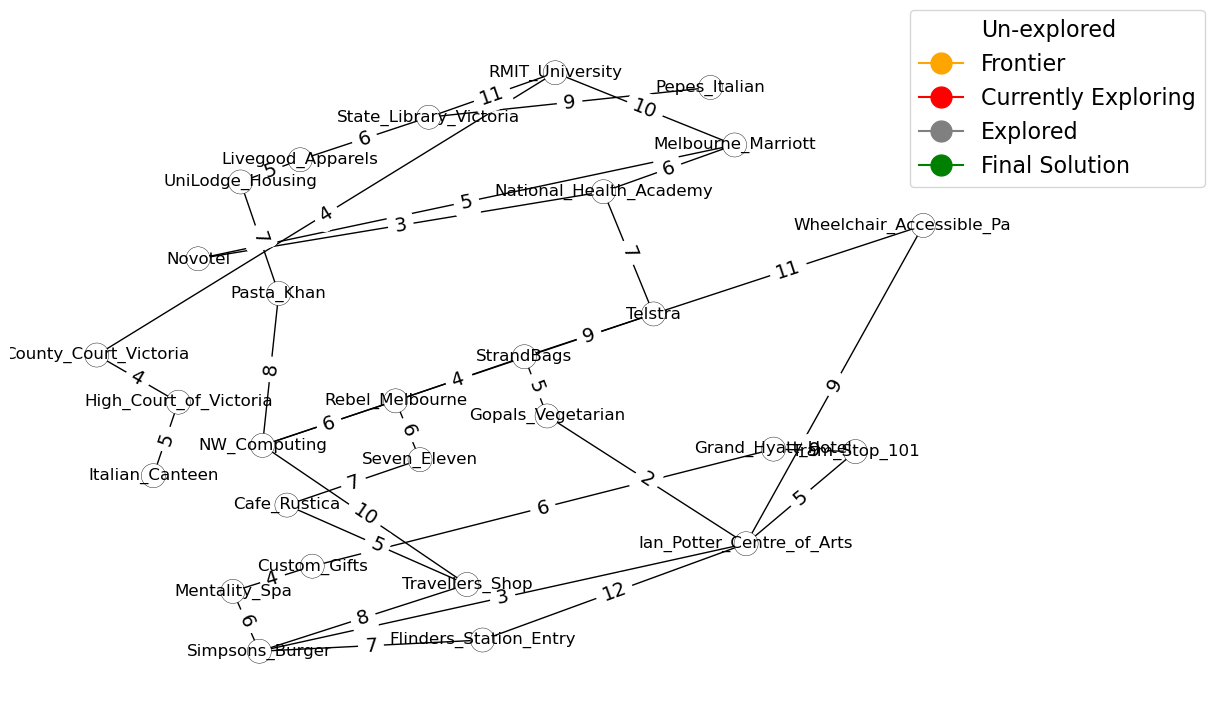

In [25]:
show_map(updated_graph_data)

In [26]:
def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem,lambda node: node.path_cost + h(node))
    return(iterations, all_node_colors, node)

In [27]:
all_node_colors = []
Distinction_problem = GraphProblem('National_Health_Academy', 'Melbourne_Marriott', updated_map,terrain_constraints= terrain_constraints, terrain_values=terrain_values)
display_visual(graph_data=updated_graph_data, user_input=False,
               algorithm=astar_search,
               problem=Distinction_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

# Task 4

In [28]:
import heapq

def dijkstra(graph, start, goal, terrain_constraints, terrain_values):
    """
    Finds the shortest path from 'start' to 'goal' in 'graph' using Dijkstra's algorithm,
    considering terrain constraints.

    Args:
        graph: A dictionary representing the graph where keys are nodes and values are dictionaries
               of neighbors with associated edge costs.
        start: The starting node.
        goal: The goal node.
        terrain_constraints: A dictionary mapping edges to terrain types.
        terrain_values: A dictionary mapping terrain types to penalty values.

    Returns:
        A tuple containing:
            - The shortest distance from 'start' to 'goal'.
            - A list of nodes representing the shortest path from 'start' to 'goal'.
    """
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    predecessors = {}
    priority_queue = [(0, start)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_node == goal:
            break

        if current_distance > distances[current_node]:
            continue

        for neighbor, weight in graph[current_node].items():
            # Get terrain penalty for the edge
            edge = (current_node, neighbor)
            if edge not in terrain_constraints:
                edge = (neighbor, current_node)  # Check reverse edge for undirected graph
            terrain_type = terrain_constraints.get(edge)
            terrain_penalty = terrain_values.get(terrain_type, 0)

            distance = current_distance + weight + terrain_penalty  # Add terrain penalty to cost
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    current = goal
    while current in predecessors:
        path.insert(0, current)
        current = predecessors[current]
    path.insert(0, start)

    return distances[goal], path

In [29]:
shortest_distance, shortest_path = dijkstra(updated_map.graph_dict, 'StrandBags', 'Wheelchair_Accessible_Parking', terrain_constraints, terrain_values)
print("Shortest distance:", shortest_distance)
print("Shortest path:", shortest_path)

Shortest distance: 20
Shortest path: ['StrandBags', 'Telstra', 'Wheelchair_Accessible_Parking']


In [31]:
# Get start and end points from user input
start_node = input("Enter the start node: ")
end_node = input("Enter the end node: ")

# Dijkstra's search
shortest_distance_dijkstra, shortest_path_dijkstra = dijkstra(updated_map.graph_dict, start_node, end_node, terrain_constraints, terrain_values)
print("\nDijkstra's Search Results:")
print("Shortest distance:", shortest_distance_dijkstra)
print("Shortest path:", shortest_path_dijkstra)

# A* search
# Create a new GraphProblem instance with user-provided start and end nodes
problem_a_star = GraphProblem(start_node, end_node, updated_map, terrain_constraints=terrain_constraints, terrain_values=terrain_values) 
iterations, all_node_colors, node = astar_search(problem_a_star)
a_star_path = node.solution()
a_star_distance = node.path_cost

print("\nA* Search Results:")
print("Shortest path:", a_star_path)
print("Shortest distance:", a_star_distance)

Enter the start node:  RMIT_University
Enter the end node:  Flinders_Station_Entry



Dijkstra's Search Results:
Shortest distance: 59
Shortest path: ['RMIT_University', 'Melbourne_Marriott', 'Novotel', 'National_Health_Academy', 'Telstra', 'NW_Computing', 'Travellers_Shop', 'Simpsons_Burger', 'Flinders_Station_Entry']

A* Search Results:
Shortest path: ['Melbourne_Marriott', 'Novotel', 'National_Health_Academy', 'Telstra', 'NW_Computing', 'Travellers_Shop', 'Simpsons_Burger', 'Flinders_Station_Entry']
Shortest distance: 59
